In [1]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
import glob
import seaborn as sns
import ast
from collections import defaultdict

def load_experiment_data_npz(results_path):
    """
    Load all experiment NPZ files from the specified path
    
    Args:
        results_path: Path to directory containing NPZ files
    
    Returns:
        List of dictionaries with experiment data
    """
    all_data = []
    npz_files = glob.glob(os.path.join(results_path, '*.npz'))
    
    print(f"Found {len(npz_files)} NPZ files")
    
    for file_path in npz_files:
        try:
            # Load the NPZ file
            data = np.load(file_path, allow_pickle=True)
            
            # Extract arrays
            batch_train_losses = data['batch_train_losses']
            iteration_numbers = data['iteration_numbers']
            test_losses = data['test_losses']
            
            # The metadata is stored as a string in an array
            metadata_str = str(data['metadata'][0])
            
            # Convert string representation back to dictionary
            # Using ast.literal_eval to safely evaluate the string as a dict
            try:
                metadata = ast.literal_eval(metadata_str)
            except:
                # Fallback to parsing from the metadata JSON if available
                meta_json_path = file_path.replace('.npz', '_meta.json')
                if os.path.exists(meta_json_path):
                    with open(meta_json_path, 'r') as f:
                        metadata = json.load(f)
                else:
                    print(f"Warning: Could not parse metadata for {file_path}")
                    continue
            
            # Combine everything into a single dictionary
            experiment = {
                **metadata,                            # All metadata fields
                'batch_train_losses': batch_train_losses,  # Training losses
                'iteration_numbers': iteration_numbers     # Iteration numbers
            }
            
            # Add test losses if they exist
            if 'test_losses' in data:
                experiment['test_losses'] = test_losses
            
            if 'test_iteration_numbers' in data:
                experiment['test_iteration_numbers'] = data['test_iteration_numbers']
            
            all_data.append(experiment)
            
        except Exception as e:
            print(f"Error loading {file_path}: {str(e)}")
    
    print(f"Successfully loaded {len(all_data)} experiments")
    return all_data

def smooth_losses(losses, window_size=100):
    """
    Compute smoothed losses by averaging every window_size iterations
    and calculate standard error
    
    Args:
        losses: List or array of loss values
        window_size: Number of iterations to average over
    
    Returns:
        tuple of (smoothed_losses, std_errors, x_ticks)
    """
    # Handle edge case with very short losses
    if len(losses) < window_size:
        window_size = max(1, len(losses) // 2)
    
    # Split losses into chunks of window_size
    chunks = [losses[i:i + window_size] for i in range(0, len(losses), window_size)]
    
    # Calculate mean and standard error for each chunk
    means = [np.mean(chunk) for chunk in chunks]
    std_errors = [np.std(chunk) / np.sqrt(len(chunk)) if len(chunk) > 1 else 0 for chunk in chunks]
    
    # X-axis positions (middle of each window)
    x_ticks = [(i + 0.5) * window_size for i in range(len(means))]
    
    return means, std_errors, x_ticks

def create_stylized_plot(experiments, function_name, window_size=100, show_error=False, save_path=None):
    """
    Create a stylized plot for a specific function grouped by learning rate
    
    Args:
        experiments: List of processed experiment data
        function_name: Name of the function to plot
        window_size: Number of iterations to average over (default: 100)
        show_error: Whether to show error bands (default: False)
        save_path: Path to save the plot (optional)
    """
    # Filter experiments for the specified function
    function_exps = [exp for exp in experiments if exp['function_name'] == function_name]
    
    if not function_exps:
        print(f"No experiments found for function: {function_name}")
        return
    
    # Group experiments by learning rate
    lr_groups = defaultdict(list)
    for exp in function_exps:
        lr_groups[exp['learning_rate']].append(exp)
    
    # Determine grid layout
    num_lrs = len(lr_groups)
    cols = min(3, num_lrs)
    rows = (num_lrs + cols - 1) // cols
    
    # Create figure
    fig, axes = plt.subplots(rows, cols, figsize=(6*cols, 5*rows), squeeze=False)
    fig.suptitle(f'Training Loss for {function_name}', fontsize=16)
    
    # Flatten axes for easier indexing
    axes = axes.flatten()
    
    # Define colors for dimensions
    dim_colors = {
        10: '#1f77b4',  # blue
        15: '#2ca02c',  # green
        20: '#d62728',  # red
        25: '#9467bd',  # purple
        30: '#ff7f0e',  # orange
        35: '#8c564b',  # brown
        50: '#e377c2',  # pink
        80: '#7f7f7f',  # gray
        100: '#17becf'  # cyan
    }
    
    # Define line styles for hidden sizes
    width_styles = {
        64: '-',
        128: '--',
        256: '-.',
        512: ':',
        1024: '-',
        2048: '--'
    }
    
    # Define markers for depths
    depth_markers = {
        1: 'o',
        2: 's',
        4: '^',
        6: 'D',
        8: 'x'
    }
    
    # Plot each learning rate
    for i, (lr, lr_exps) in enumerate(sorted(lr_groups.items())):
        ax = axes[i]
        
        # Track legend entries to avoid duplicates
        legend_entries = []
        
        # Process all experiments for this learning rate
        for exp in lr_exps:
            try:
                hidden_size = exp['hidden_size']
                depth = exp['depth']
                mode = exp['mode']
                dim = exp['input_dim']
                is_aligned = exp['alignment']
                
                # Skip if no losses
                if 'batch_train_losses' not in exp or len(exp['batch_train_losses']) == 0:
                    continue
                
                # Get color based on dimension
                color = dim_colors.get(dim, 'black')
                
                # Get line style based on hidden size
                linestyle = width_styles.get(hidden_size, '-')
                
                # Get marker based on depth
                marker = depth_markers.get(depth, 'o')
                
                # Create label
                label = f"d={dim}, h={hidden_size}, depth={depth}, {mode}"
                if is_aligned:
                    label += ", aligned"
                
                # Check if this exact label is already in legend
                if label in legend_entries:
                    show_label = None  # Don't add to legend
                else:
                    legend_entries.append(label)
                    show_label = label
                
                # Apply smoothing with window_size
                means, std_errors, x_ticks = smooth_losses(exp['batch_train_losses'], window_size)
                
                # Plot mean line
                ax.plot(x_ticks, means, 
                       linestyle=linestyle,
                       marker=marker,
                       markersize=4,
                       markevery=max(1, len(means)//10),  # Show fewer markers
                       color=color,
                       alpha=0.8 if mode == "standard" else 0.6,
                       label=show_label)
                
                # Add error bands if requested
                if show_error:
                    ax.fill_between(
                        x_ticks,
                        [m - se for m, se in zip(means, std_errors)],
                        [m + se for m, se in zip(means, std_errors)],
                        color=color,
                        alpha=0.1
                    )
                    
            except Exception as e:
                print(f"Error plotting experiment: {str(e)}")
        
        # Configure subplot
        ax.set_xlabel(f'Iterations (x{window_size})')
        ax.set_ylabel('Training Loss')
        ax.set_yscale('log')
        ax.set_title(f'LR: {lr}')
        ax.grid(True, alpha=0.3)
        
        # Add legend with smaller font size to save space
        if legend_entries:
            ax.legend(fontsize='small', loc='best')
    
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    
    # Save if path specified
    if save_path:
        os.makedirs(save_path, exist_ok=True)
        plt.savefig(os.path.join(save_path, f'{function_name}_loss_w{window_size}.png'), 
                   dpi=300, bbox_inches='tight')
    
    plt.show()

def check_checkpoint_progress(checkpoint_file, config_file=None):
    """
    Check progress of training by analyzing checkpoint file
    
    Args:
        checkpoint_file: Path to checkpoint file
        config_file: Optional path to YAML config file to calculate total configurations
    
    Returns:
        Dictionary with progress information
    """
    import yaml
    
    # Read completed configurations from checkpoint
    completed_configs = set()
    if os.path.exists(checkpoint_file):
        with open(checkpoint_file, 'r') as f:
            completed_configs = set(line.strip() for line in f)
    
    result = {
        'completed': len(completed_configs),
        'checkpoint_file': checkpoint_file
    }
    
    # If config file provided, calculate total configurations
    if config_file and os.path.exists(config_file):
        with open(config_file, 'r') as f:
            config = yaml.safe_load(f)
        
        # Count total configurations (simplified estimation)
        functions = len(config.get('functions', []))
        lr_count = len(config.get('sweeps', {}).get('learning_rates', []))
        hidden_sizes = len(config.get('sweeps', {}).get('hidden_sizes', []))
        depths = len(config.get('sweeps', {}).get('depths', []))
        modes = len(config.get('sweeps', {}).get('modes', []))
        alignments = len(config.get('sweeps', {}).get('alignment', []))
        
        # Estimate total combinations (approximation)
        total_configs = functions * lr_count * hidden_sizes * depths * modes * alignments
        
        result['total'] = total_configs
        result['percent_complete'] = round(len(completed_configs) / max(1, total_configs) * 100, 2)
    
    return result

def analyze_all_functions(results_path, window_size=100, show_error=False, save_path=None):
    """
    Analyze and plot all functions found in the results directory
    
    Args:
        results_path: Path to directory containing NPZ files
        window_size: Number of iterations to average over (default: 100)
        show_error: Whether to show error bands (default: False)
        save_path: Path to save the plots (optional)
    """
    # Check for checkpoint file and report progress
    checkpoint_files = glob.glob(os.path.join(results_path, "checkpoint_*.txt"))
    if checkpoint_files:
        latest_checkpoint = max(checkpoint_files, key=os.path.getmtime)
        config_file = os.path.join(results_path, "config.yaml")
        
        progress = check_checkpoint_progress(latest_checkpoint, config_file)
        print(f"Training progress: {progress.get('completed', 0)} completed configurations")
        if 'percent_complete' in progress:
            print(f"Approximately {progress['percent_complete']}% complete")
    
    # Load all experiment data
    all_data = load_experiment_data_npz(results_path)
    
    if not all_data:
        print("No valid experiment data found.")
        return
    
    # Get unique function names
    function_names = set()
    for exp in all_data:
        if 'function_name' in exp:
            function_names.add(exp['function_name'])
    
    print(f"Found {len(function_names)} functions: {', '.join(function_names)}")
    
    # Plot each function
    for function_name in sorted(function_names):
        print(f"Plotting {function_name}...")
        create_stylized_plot(
            all_data, 
            function_name,
            window_size=window_size,
            show_error=show_error,
            save_path=save_path
        )

# Example usage in a notebook:
"""
# Set the path to your NPZ results
results_path = "/path/to/your/npz/files"

# Load all experiment data
data = load_experiment_data_npz(results_path)

# Create plot for a specific function with 100-iteration windows
create_stylized_plot(
    data, 
    "leap_1",
    window_size=100,  
    show_error=False,  # Set to True to show error bands
    save_path="./plots"
)

# Or analyze all functions in the results directory
analyze_all_functions(
    results_path,
    window_size=100,
    show_error=False,
    save_path="./plots"
)
"""

'\n# Set the path to your NPZ results\nresults_path = "/path/to/your/npz/files"\n\n# Load all experiment data\ndata = load_experiment_data_npz(results_path)\n\n# Create plot for a specific function with 100-iteration windows\ncreate_stylized_plot(\n    data, \n    "leap_1",\n    window_size=100,  \n    show_error=False,  # Set to True to show error bands\n    save_path="./plots"\n)\n\n# Or analyze all functions in the results directory\nanalyze_all_functions(\n    results_path,\n    window_size=100,\n    show_error=False,\n    save_path="./plots"\n)\n'

Found 22 NPZ files
Error loading /home/goring/OnlineSGD/results_MSP/MSP_0405_20/leap_exp_20250405_145644/leap_1_d50_h2048_depth4_lr0.001_modestandard_exp1_align.npz: No data left in file
Error loading /home/goring/OnlineSGD/results_MSP/MSP_0405_20/leap_exp_20250405_145644/leap_4_d50_h2048_depth4_lr0.01_modemup_exp1_align.npz: File is not a zip file


Error loading /home/goring/OnlineSGD/results_MSP/MSP_0405_20/leap_exp_20250405_145644/leap_1_d20_h2048_depth4_lr0.001_modestandard_exp1_align.npz: No data left in file
Error loading /home/goring/OnlineSGD/results_MSP/MSP_0405_20/leap_exp_20250405_145644/leap_4_d80_h2048_depth4_lr0.01_modemup_exp1_align.npz: File is not a zip file
Error loading /home/goring/OnlineSGD/results_MSP/MSP_0405_20/leap_exp_20250405_145644/leap_8_d80_h512_depth4_lr0.001_modemup_exp1_align.npz: No data left in file
Error loading /home/goring/OnlineSGD/results_MSP/MSP_0405_20/leap_exp_20250405_145644/leap_1_d80_h2048_depth4_lr0.001_modestandard_exp1_align.npz: No data left in file
Error loading /home/goring/OnlineSGD/results_MSP/MSP_0405_20/leap_exp_20250405_145644/leap_8_d35_h512_depth4_lr0.001_modemup_exp1_align.npz: File is not a zip file
Error loading /home/goring/OnlineSGD/results_MSP/MSP_0405_20/leap_exp_20250405_145644/leap_8_d20_h512_depth4_lr0.001_modemup_exp1_align.npz: No data left in file
Error loadin

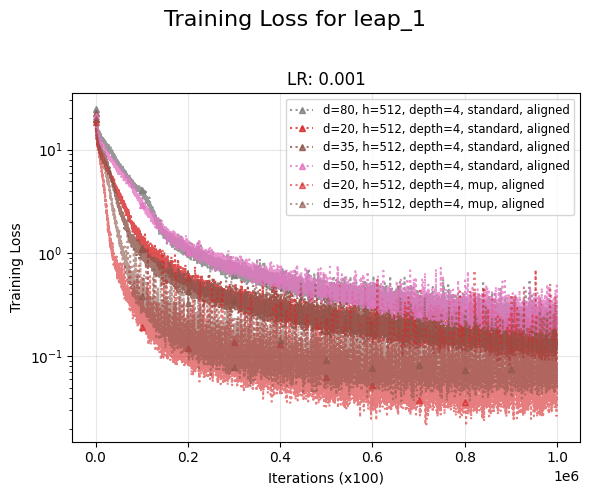

Plotting leap_8...


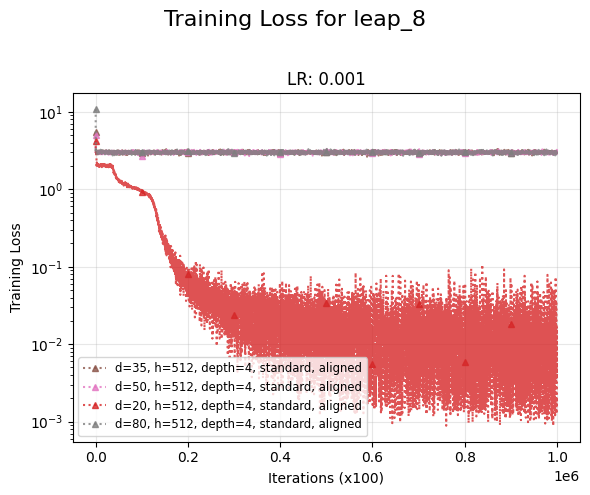

In [3]:
# Set the path to your NPZ results
results_path = "/home/goring/OnlineSGD/results_MSP/MSP_0405_20/leap_exp_20250405_145644"

# Load all experiment data
data = load_experiment_data_npz(results_path)
analyze_all_functions(
    results_path,
    window_size=100,
    show_error=False,
    save_path="./plots"
)


In [2]:
# Set the path to your NPZ results
results_path = "/home/goring/OnlineSGD/results_MSP/MSP_0405_20/leap_exp_20250406_044048"

# Load all experiment data
data = load_experiment_data_npz(results_path)
analyze_all_functions(
    results_path,
    window_size=100,
    show_error=False,
    save_path="./plots"
)


Found 64 NPZ files
Error loading /home/goring/OnlineSGD/results_MSP/MSP_0405_20/leap_exp_20250406_044048/leap_1_d20_h512_depth1_lr0.001_modestandard_exp1_align.npz: 'batch_train_losses is not a file in the archive'
Error loading /home/goring/OnlineSGD/results_MSP/MSP_0405_20/leap_exp_20250406_044048/leap_1_d50_h512_depth4_lr0.001_modestandard_exp1_align.npz: 'batch_train_losses is not a file in the archive'
Error loading /home/goring/OnlineSGD/results_MSP/MSP_0405_20/leap_exp_20250406_044048/leap_1_d80_h2048_depth1_lr0.001_modestandard_exp1_align.npz: 'batch_train_losses is not a file in the archive'
Error loading /home/goring/OnlineSGD/results_MSP/MSP_0405_20/leap_exp_20250406_044048/leap_1_d80_h512_depth4_lr0.0001_modemup_exp1_align.npz: 'batch_train_losses is not a file in the archive'
Error loading /home/goring/OnlineSGD/results_MSP/MSP_0405_20/leap_exp_20250406_044048/leap_1_d80_h2048_depth4_lr0.0001_modemup_exp1_align.npz: 'batch_train_losses is not a file in the archive'
Error l

In [1]:
#!/usr/bin/env python3
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from collections import defaultdict
from typing import Dict, List, Tuple, Any

def load_results(results_dir: str) -> Dict:
    """Load experiment results from NPZ files in the specified directory."""
    npz_files = glob.glob(os.path.join(results_dir, "*.npz"))
    print(f"Found {len(npz_files)} result files in {results_dir}")
    
    results = {}
    
    for npz_file in npz_files:
        try:
            with np.load(npz_file, allow_pickle=True) as data:
                # Extract metadata
                metadata_str = str(data['metadata'][0])
                metadata = eval(metadata_str)
                
                unique_id = metadata['unique_id']
                
                # Load training and test metrics
                train_stats = data['train_stats']
                test_metrics = data['test_metrics']
                
                # Load term test losses if available
                term_losses = None
                term_descriptions = None
                
                if 'term_iterations' in data and 'term_losses' in data:
                    term_iterations = data['term_iterations']
                    term_losses_array = data['term_losses']
                    
                    # Store iterations and losses separately
                    term_losses = {
                        'iterations': term_iterations,
                        'values': term_losses_array
                    }
                
                if 'term_descriptions' in data:
                    term_descriptions = data['term_descriptions']
                
                # Store in results dictionary
                results[unique_id] = {
                    'metadata': metadata,
                    'train_stats': train_stats,
                    'test_metrics': test_metrics,
                    'term_losses': term_losses,
                    'term_descriptions': term_descriptions
                }
        except Exception as e:
            print(f"Error loading {npz_file}: {str(e)}")
    
    return results

def group_results_by_function(results: Dict) -> Dict[str, List]:
    """Group results by function name."""
    grouped = defaultdict(list)
    
    for unique_id, result_data in results.items():
        function_name = result_data['metadata'].get('function_name', 'unknown')
        grouped[function_name].append((unique_id, result_data))
    
    return grouped

def get_hyperparameter_groups(results_for_function: List[Tuple[str, Dict]]) -> Tuple[List, Dict]:
    """
    Group results by hyperparameter combinations (hidden_size, depth, lr).
    Returns unique combinations and a dictionary mapping dimensions to hyperparameter groups.
    """
    # Extract unique hyperparameter combinations
    hyper_combos = set()
    for _, result_data in results_for_function:
        metadata = result_data['metadata']
        combo = (
            metadata.get('hidden_size', None),
            metadata.get('depth', None),
            metadata.get('learning_rate', None)
        )
        hyper_combos.add(combo)
    
    # Sort combinations
    hyper_combos = sorted(list(hyper_combos))
    
    # Group results by dimension and hyperparameter combination
    dim_to_hyper = defaultdict(dict)
    for unique_id, result_data in results_for_function:
        metadata = result_data['metadata']
        dim = metadata.get('input_dim', None)
        combo = (
            metadata.get('hidden_size', None),
            metadata.get('depth', None),
            metadata.get('learning_rate', None)
        )
        dim_to_hyper[dim][combo] = result_data
    
    return hyper_combos, dim_to_hyper

def plot_function_results(function_name: str, results_for_function: List[Tuple[str, Dict]], output_dir: str):
    """Create a grid of plots for a specific function."""
    # Group by hyperparameters and dimensions
    hyper_combos, dim_to_hyper = get_hyperparameter_groups(results_for_function)
    dimensions = sorted(dim_to_hyper.keys())
    
    # Determine grid size
    n_combos = len(hyper_combos)
    n_dims = len(dimensions)
    
    # Create the figure with a grid
    fig_height = 5 * n_dims  # 5 inches per dimension
    fig_width = 4 * n_combos  # 4 inches per hyperparameter combination
    
    fig = plt.figure(figsize=(fig_width, fig_height))
    
    # Create a grid with 2 rows per dimension (one for train error, one for test error)
    gs = GridSpec(2 * n_dims, n_combos, figure=fig, hspace=0.3, wspace=0.3)
    
    # Add a title for the entire figure
    fig.suptitle(f"Results for {function_name}", fontsize=16)
    
    # Create column headers for hyperparameter combinations
    for col_idx, (hidden_size, depth, lr) in enumerate(hyper_combos):
        header_text = f"h={hidden_size}, d={depth}, lr={lr}"
        fig.text(
            (col_idx + 0.5) / n_combos, 0.98, 
            header_text, 
            ha='center', va='top', 
            fontsize=10, fontweight='bold'
        )
    
    # Create plots for each dimension and hyperparameter combination
    for dim_idx, dim in enumerate(dimensions):
        # Add row label for this dimension
        fig.text(
            0.01, 1.0 - (dim_idx * 2 + 1) / (2 * n_dims), 
            f"dim={dim}", 
            ha='left', va='center', 
            fontsize=10, fontweight='bold', 
            rotation=90
        )
        
        for col_idx, combo in enumerate(hyper_combos):
            if combo in dim_to_hyper[dim]:
                result_data = dim_to_hyper[dim][combo]
                
                # Training error plot (top)
                ax_train = fig.add_subplot(gs[2 * dim_idx, col_idx])
                train_stats = result_data['train_stats']
                iterations = train_stats[:, 0]
                mean_losses = train_stats[:, 1]
                
                ax_train.plot(iterations, mean_losses, 'b-', label='Train Loss')
                ax_train.set_xscale('log')
                ax_train.set_yscale('log')
                ax_train.set_ylabel('Loss')
                ax_train.set_title(f"Training Error")
                ax_train.grid(True, which='both', linestyle='--', linewidth=0.5)
                
                # Test error plot (bottom)
                ax_test = fig.add_subplot(gs[2 * dim_idx + 1, col_idx])
                
                # Plot overall test error
                test_metrics = result_data['test_metrics']
                test_iterations = test_metrics[:, 0]
                test_losses = test_metrics[:, 1]
                
                ax_test.plot(test_iterations, test_losses, 'r-', linewidth=2, label='Overall Test Loss')
                
                # Plot individual term test losses if available
                if result_data['term_losses'] is not None:
                    term_data = result_data['term_losses']
                    term_descriptions = result_data['term_descriptions']
                    
                    # Access iterations and values arrays directly
                    term_iterations = term_data['iterations']
                    term_losses_array = term_data['values']
                    
                    # Plot each term's test loss
                    colors = plt.cm.tab10.colors
                    n_terms = term_losses_array.shape[1] if len(term_losses_array.shape) > 1 else 1
                    
                    for t_idx in range(n_terms):
                        # Get description for this term
                        term_desc = term_descriptions[t_idx] if term_descriptions is not None else f"Term {t_idx+1}"
                        term_label = f"Term {t_idx+1}" if len(term_desc) > 25 else term_desc
                        
                        # Get loss values for this term
                        if len(term_losses_array.shape) > 1:
                            term_loss_values = term_losses_array[:, t_idx]
                        else:
                            term_loss_values = term_losses_array
                        
                        # Make sure iterations and values have the same length
                        if len(term_iterations) == len(term_loss_values):
                            ax_test.plot(
                                term_iterations,
                                term_loss_values,
                                color=colors[t_idx % len(colors)],
                                linestyle='-',
                                linewidth=1.5,
                                label=term_label
                            )
                        else:
                            print(f"Warning: Skipping term {t_idx+1} due to shape mismatch - iterations: {term_iterations.shape}, values: {term_loss_values.shape}")
                
                ax_test.set_xscale('log')
                ax_test.set_yscale('log')
                ax_test.set_xlabel('Iterations')
                ax_test.set_ylabel('Loss')
                ax_test.set_title(f"Test Error")
                ax_test.grid(True, which='both', linestyle='--', linewidth=0.5)
                
                # Add legend to the test plot
                ax_test.legend(loc='best', fontsize='small')
            else:
                # If no match found, create empty subplot with message
                ax_train = fig.add_subplot(gs[2 * dim_idx, col_idx])
                ax_train.text(0.5, 0.5, "No data", ha='center', va='center')
                ax_train.axis('off')
                
                ax_test = fig.add_subplot(gs[2 * dim_idx + 1, col_idx])
                ax_test.text(0.5, 0.5, "No data", ha='center', va='center')
                ax_test.axis('off')
    
    # Adjust the layout and save
    plt.tight_layout(rect=[0.02, 0.02, 0.98, 0.96])
    
    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)
    
    # Save the figure
    output_path = os.path.join(output_dir, f"{function_name}_results.png")
    plt.savefig(output_path, dpi=150, bbox_inches='tight')
    print(f"Saved plot to {output_path}")
    
    # Close the figure to free memory
    plt.close(fig)

def main():
    # HARDCODED PATHS: Specify your directories here
    results_dir = "/home/goring/OnlineSGD/results_MSP/Phi_0407_mup/complex_leap_exp_20250407_035759"
    output_dir = "plots"
    
    # Load results
    results = load_results(results_dir)
    print(f"Loaded {len(results)} experiment results")
    
    # Group by function
    grouped_results = group_results_by_function(results)
    print(f"Found results for {len(grouped_results)} different functions")
    
    # Create plots for each function
    for function_name, results_for_function in grouped_results.items():
        print(f"Creating plots for {function_name} ({len(results_for_function)} results)")
        plot_function_results(function_name, results_for_function, output_dir)

if __name__ == "__main__":
    main()

Found 0 result files in /home/goring/OnlineSGD/results_MSP/Phi_0407_mup/complex_leap_exp_20250407_035759
Loaded 0 experiment results
Found results for 0 different functions


In [25]:
def main():
    # HARDCODED PATHS: Specify your directories here
    results_dir = "/home/goring/OnlineSGD/results_MSP/Phi_0407_mup_binary/complex_leap_exp_20250407_051855"
    output_dir = "plots"
    
    # Load results
    results = load_results(results_dir)
    print(f"Loaded {len(results)} experiment results")
    
    # Group by function
    grouped_results = group_results_by_function(results)
    print(f"Found results for {len(grouped_results)} different functions")
    
    # Create plots for each function
    for function_name, results_for_function in grouped_results.items():
        print(f"Creating plots for {function_name} ({len(results_for_function)} results)")
        plot_function_results(function_name, results_for_function, output_dir)

if __name__ == "__main__":
    main()

Found 288 result files in /home/goring/OnlineSGD/results_MSP/Phi_0407_mup_binary/complex_leap_exp_20250407_051855
Error loading /home/goring/OnlineSGD/results_MSP/Phi_0407_mup_binary/complex_leap_exp_20250407_051855/4_1_d40_h2048_depth4_lr0.001_modemup_distbinary_exp1_align.npz: name 'nan' is not defined
Error loading /home/goring/OnlineSGD/results_MSP/Phi_0407_mup_binary/complex_leap_exp_20250407_051855/4_4_d80_h2048_depth4_lr0.005_modemup_distbinary_exp1_align.npz: name 'nan' is not defined
Error loading /home/goring/OnlineSGD/results_MSP/Phi_0407_mup_binary/complex_leap_exp_20250407_051855/4_all_d40_h512_depth4_lr0.005_modemup_distbinary_exp1_align.npz: name 'nan' is not defined
Error loading /home/goring/OnlineSGD/results_MSP/Phi_0407_mup_binary/complex_leap_exp_20250407_051855/4_all_d20_h512_depth4_lr0.005_modemup_distbinary_exp1_align.npz: name 'nan' is not defined
Error loading /home/goring/OnlineSGD/results_MSP/Phi_0407_mup_binary/complex_leap_exp_20250407_051855/4_leap_1_d20_h

/tmp/ipykernel_2685963/2966502604.py:297: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_pti.legend(loc='best', fontsize='small')
/tmp/ipykernel_2685963/2966502604.py:347: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_grad.legend(loc='best', fontsize='small')
/tmp/ipykernel_2685963/2966502604.py:358: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0.02, 0.02, 0.98, 0.96])


Saved plot to plots/4_id_results.png
Creating plots for 4_tanh (36 results)
Saved plot to plots/4_tanh_results.png
Creating plots for 4_1 (35 results)
Saved plot to plots/4_1_results.png
Creating plots for 4_4 (35 results)
Saved plot to plots/4_4_results.png
Creating plots for 4_all (34 results)
Saved plot to plots/4_all_results.png
Creating plots for 4_sin (36 results)
Saved plot to plots/4_sin_results.png
Creating plots for 4_leap_100 (36 results)
Saved plot to plots/4_leap_100_results.png
Creating plots for 4_leap_1 (35 results)
Saved plot to plots/4_leap_1_results.png


In [7]:
def main():
    # HARDCODED PATHS: Specify your directories here
    results_dir = "/home/goring/OnlineSGD/results_MSP/Phi_0407_mup_normal/complex_leap_exp_20250407_051805"
    output_dir = "plots"
    
    # Load results
    results = load_results(results_dir)
    print(f"Loaded {len(results)} experiment results")
    
    # Group by function
    grouped_results = group_results_by_function(results)
    print(f"Found results for {len(grouped_results)} different functions")
    
    # Create plots for each function
    for function_name, results_for_function in grouped_results.items():
        print(f"Creating plots for {function_name} ({len(results_for_function)} results)")
        plot_function_results(function_name, results_for_function, output_dir)

if __name__ == "__main__":
    main()

Found 148 result files in /home/goring/OnlineSGD/results_MSP/Phi_0407_mup_normal/complex_leap_exp_20250407_051805
Loaded 148 experiment results
Found results for 5 different functions
Creating plots for 4_id (36 results)


/tmp/ipykernel_2659369/3016219175.py:230: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0.02, 0.02, 0.98, 0.96])


Saved plot to plots/4_id_results.png
Creating plots for 4_sin (36 results)
Saved plot to plots/4_sin_results.png
Creating plots for 4_all (36 results)
Saved plot to plots/4_all_results.png
Creating plots for 4_tanh (36 results)
Saved plot to plots/4_tanh_results.png
Creating plots for 4_leap_1 (4 results)
Saved plot to plots/4_leap_1_results.png


In [ ]:
### adapted plots for new metrics

In [2]:
#!/usr/bin/env python3
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import ticker
from matplotlib.gridspec import GridSpec
from collections import defaultdict
from typing import Dict, List, Tuple, Any

def load_results(results_dir: str) -> Dict:
    """Load experiment results from NPZ files in the specified directory."""
    npz_files = glob.glob(os.path.join(results_dir, "*.npz"))
    print(f"Found {len(npz_files)} result files in {results_dir}")
    
    results = {}
    
    for npz_file in npz_files:
        try:
            with np.load(npz_file, allow_pickle=True) as data:
                # Extract metadata
                metadata_str = str(data['metadata'][0])
                metadata = eval(metadata_str)
                
                unique_id = metadata['unique_id']
                
                # Load training and test metrics
                train_stats = data['train_stats']
                test_metrics = data['test_metrics']
                
                # Load term test losses if available
                term_losses = None
                term_descriptions = None
                
                if 'term_iterations' in data and 'term_losses' in data:
                    term_iterations = data['term_iterations']
                    term_losses_array = data['term_losses']
                    
                    # Store iterations and values separately
                    term_losses = {
                        'iterations': term_iterations,
                        'values': term_losses_array
                    }
                
                if 'term_descriptions' in data:
                    term_descriptions = data['term_descriptions']
                
                # Load Progressive Term Isolation metrics if available
                pti_metrics = None
                if all(key in data for key in ['pti_iterations', 'pti_correlation_ratios', 'pti_residual_mse']):
                    pti_metrics = {
                        'iterations': data['pti_iterations'],
                        'correlation_ratios': data['pti_correlation_ratios'],
                        'residual_mse': data['pti_residual_mse']
                    }
                
                # Load Gradient Alignment metrics if available
                grad_metrics = None
                if all(key in data for key in ['grad_iterations', 'grad_alignment', 'grad_magnitude_ratio']):
                    grad_metrics = {
                        'iterations': data['grad_iterations'],
                        'alignment': data['grad_alignment'],
                        'magnitude_ratio': data['grad_magnitude_ratio']
                    }
                
                # Store in results dictionary
                results[unique_id] = {
                    'metadata': metadata,
                    'train_stats': train_stats,
                    'test_metrics': test_metrics,
                    'term_losses': term_losses,
                    'term_descriptions': term_descriptions,
                    'pti_metrics': pti_metrics,
                    'grad_metrics': grad_metrics
                }
        except Exception as e:
            print(f"Error loading {npz_file}: {str(e)}")
    
    return results

def group_results_by_function(results: Dict) -> Dict[str, List]:
    """Group results by function name."""
    grouped = defaultdict(list)
    
    for unique_id, result_data in results.items():
        function_name = result_data['metadata'].get('function_name', 'unknown')
        grouped[function_name].append((unique_id, result_data))
    
    return grouped

def get_hyperparameter_groups(results_for_function: List[Tuple[str, Dict]]) -> Tuple[List, Dict]:
    """
    Group results by hyperparameter combinations (hidden_size, depth, lr).
    Returns unique combinations and a dictionary mapping dimensions to hyperparameter groups.
    """
    # Extract unique hyperparameter combinations
    hyper_combos = set()
    for _, result_data in results_for_function:
        metadata = result_data['metadata']
        combo = (
            metadata.get('hidden_size', None),
            metadata.get('depth', None),
            metadata.get('learning_rate', None),
            metadata.get('mode', 'standard_lr')  # Add mode to differentiate standard_lr vs mup
        )
        hyper_combos.add(combo)
    
    # Sort combinations
    hyper_combos = sorted(list(hyper_combos))
    
    # Group results by dimension and hyperparameter combination
    dim_to_hyper = defaultdict(dict)
    for unique_id, result_data in results_for_function:
        metadata = result_data['metadata']
        dim = metadata.get('input_dim', None)
        combo = (
            metadata.get('hidden_size', None),
            metadata.get('depth', None),
            metadata.get('learning_rate', None),
            metadata.get('mode', 'standard_lr')  # Add mode to differentiate standard_lr vs mup
        )
        dim_to_hyper[dim][combo] = result_data
    
    return hyper_combos, dim_to_hyper

def plot_function_results(function_name: str, results_for_function: List[Tuple[str, Dict]], output_dir: str):
    """Create a grid of plots for a specific function."""
    # Group by hyperparameters and dimensions
    hyper_combos, dim_to_hyper = get_hyperparameter_groups(results_for_function)
    dimensions = sorted(dim_to_hyper.keys())
    
    # Determine grid size
    n_combos = len(hyper_combos)
    n_dims = len(dimensions)
    
    # Create the figure with a grid
    fig_height = 10 * n_dims  # 10 inches per dimension (4 rows per dim)
    fig_width = 4 * n_combos  # 4 inches per hyperparameter combination
    
    fig = plt.figure(figsize=(fig_width, fig_height))
    
    # Create a grid with 4 rows per dimension (train, test, pti, grad)
    gs = GridSpec(4 * n_dims, n_combos, figure=fig, hspace=0.3, wspace=0.3)
    
    # Add a title for the entire figure
    fig.suptitle(f"Results for {function_name}", fontsize=16)
    
    # Hardcode the maximum iterations to match what's in the config
    # This avoids potential overflow issues and unexpected scaling
    max_iterations = 5000000
    
    # Print what we're using
    print(f"Using maximum x-axis limit of {max_iterations} iterations")
    
    # Create column headers for hyperparameter combinations
    for col_idx, (hidden_size, depth, lr, mode) in enumerate(hyper_combos):
        header_text = f"h={hidden_size}, d={depth}, lr={lr}, mode={mode}"
        fig.text(
            (col_idx + 0.5) / n_combos, 0.98, 
            header_text, 
            ha='center', va='top', 
            fontsize=10, fontweight='bold'
        )
    
    # Create plots for each dimension and hyperparameter combination
    for dim_idx, dim in enumerate(dimensions):
        # Add row label for this dimension
        fig.text(
            0.01, 1.0 - (dim_idx * 4 + 2) / (4 * n_dims), 
            f"dim={dim}", 
            ha='left', va='center', 
            fontsize=10, fontweight='bold', 
            rotation=90
        )
        
        for col_idx, combo in enumerate(hyper_combos):
            if combo in dim_to_hyper[dim]:
                result_data = dim_to_hyper[dim][combo]
                metadata = result_data['metadata']
                
                # Training error plot (row 1)
                ax_train = fig.add_subplot(gs[4 * dim_idx, col_idx])
                train_stats = result_data['train_stats']
                
                if len(train_stats) > 0:
                    iterations = train_stats[:, 0]
                    mean_losses = train_stats[:, 1]
                    
                    ax_train.plot(iterations, mean_losses, 'b-', label='Train Loss')
                    
                    # Diagnostic info
                    test_metrics = result_data['test_metrics']
                    if len(test_metrics) > 0:
                        max_train_iter = np.max(iterations)
                        max_test_iter = np.max(test_metrics[:, 0])
                        
                        # Add a note if train data stops early
                        if max_test_iter > max_train_iter * 1.1:  # If gap is more than 10%
                            gap_percent = (max_test_iter - max_train_iter) / max_test_iter * 100
                            print(f"Data gap for dim={dim}, {combo}: Train data stops at {max_train_iter}, " 
                                f"Test data continues to {max_test_iter} (gap: {gap_percent:.1f}%)")
                            
                            # Add text annotation
                            ax_train.text(0.5, 0.9, f"Train data stops at {int(max_train_iter):,}", 
                                        transform=ax_train.transAxes, ha='center', 
                                        fontsize=8, bbox=dict(facecolor='white', alpha=0.8))
                            
                            # Add a dotted line
                            ax_train.plot([max_train_iter, max_test_iter], 
                                        [mean_losses[-1], mean_losses[-1]], 
                                        'b--', linewidth=1, alpha=0.5)
                    
                ax_train.set_xscale('log')
                #ax_train.set_yscale('log')
                ax_train.set_xlim(1, max_iterations)
                ax_train.set_ylabel('Loss')
                ax_train.set_title(f"Training Error")
                ax_train.grid(True, which='both', linestyle='--', linewidth=0.5)
                ax_train.xaxis.set_major_locator(ticker.LogLocator(base=10.0, numticks=8))
                
                # Test error plot (row 2)
                ax_test = fig.add_subplot(gs[4 * dim_idx + 1, col_idx])
                
                # Plot overall test error
                test_metrics = result_data['test_metrics']
                
                if len(test_metrics) > 0:
                    test_iterations = test_metrics[:, 0]
                    test_losses = test_metrics[:, 1]
                    
                    ax_test.plot(test_iterations, test_losses, 'r-', linewidth=2, label='Overall Test Loss')
                
                # Plot individual term test losses if available
                if result_data['term_losses'] is not None:
                    term_data = result_data['term_losses']
                    term_descriptions = result_data['term_descriptions']
                    
                    # Access iterations and values arrays directly
                    term_iterations = term_data['iterations']
                    term_losses_array = term_data['values']
                    
                    # Plot each term's test loss
                    colors = plt.cm.tab10.colors
                    n_terms = term_losses_array.shape[1] if len(term_losses_array.shape) > 1 else 1
                    
                    for t_idx in range(n_terms):
                        # Get description for this term
                        term_desc = term_descriptions[t_idx] if term_descriptions is not None else f"Term {t_idx+1}"
                        term_label = f"Term {t_idx+1}" if len(term_desc) > 25 else term_desc
                        
                        # Get loss values for this term
                        if len(term_losses_array.shape) > 1:
                            term_loss_values = term_losses_array[:, t_idx]
                        else:
                            term_loss_values = term_losses_array
                        
                        # Make sure iterations and values have the same length
                        if len(term_iterations) == len(term_loss_values):
                            ax_test.plot(
                                term_iterations,
                                term_loss_values,
                                color=colors[t_idx % len(colors)],
                                linestyle='-',
                                linewidth=1.5,
                                label=term_label
                            )
                        else:
                            print(f"Warning: Skipping term {t_idx+1} due to shape mismatch")
                
                ax_test.set_xscale('log')
                ax_test.set_yscale('log')
                ax_test.set_xlim(1, max_iterations)
                ax_test.set_xlabel('Iterations')
                ax_test.set_ylabel('Loss')
                ax_test.set_title(f"Test Error")
                ax_test.grid(True, which='both', linestyle='--', linewidth=0.5)
                ax_test.legend(loc='best', fontsize='small')
                ax_test.xaxis.set_major_locator(ticker.LogLocator(base=10.0, numticks=8))
                
                # PTI Correlation plot (row 3)
                ax_pti = fig.add_subplot(gs[4 * dim_idx + 2, col_idx])
                
                if result_data['pti_metrics'] is not None:
                    pti_data = result_data['pti_metrics']
                    term_descriptions = result_data['term_descriptions']
                    
                    # Access iterations and correlation values directly
                    pti_iterations = pti_data['iterations']
                    pti_correlation_ratios = pti_data['correlation_ratios']
                    
                    # Plot each term's correlation ratio
                    colors = plt.cm.tab10.colors
                    n_terms = pti_correlation_ratios.shape[1] if len(pti_correlation_ratios.shape) > 1 else 1
                    
                    for t_idx in range(n_terms):
                        # Get description for this term
                        term_desc = term_descriptions[t_idx] if term_descriptions is not None else f"Term {t_idx+1}"
                        term_label = f"Term {t_idx+1}" if len(term_desc) > 25 else term_desc
                        
                        # Get correlation values for this term
                        if len(pti_correlation_ratios.shape) > 1:
                            term_corr_values = pti_correlation_ratios[:, t_idx]
                        else:
                            term_corr_values = pti_correlation_ratios
                        
                        # Make sure iterations and values have the same length
                        if len(pti_iterations) == len(term_corr_values):
                            ax_pti.plot(
                                pti_iterations,
                                term_corr_values,
                                color=colors[t_idx % len(colors)],
                                linestyle='-',
                                linewidth=1.5,
                                label=term_label
                            )
                        else:
                            print(f"Warning: Skipping PTI correlation for term {t_idx+1} due to shape mismatch")
                
                ax_pti.set_xscale('log')
                ax_pti.set_ylim(-1.05, 1.05)  # Correlation ranges from -1 to 1
                ax_pti.set_xlim(1, max_iterations)
                ax_pti.axhline(y=0, color='k', linestyle='--', alpha=0.5)  # Zero line
                ax_pti.set_xlabel('Iterations')
                ax_pti.set_ylabel('Correlation')
                ax_pti.set_title(f"Term Correlation Ratios (PTI)")
                ax_pti.grid(True, which='both', linestyle='--', linewidth=0.5)
                ax_pti.legend(loc='best', fontsize='small')
                ax_pti.xaxis.set_major_locator(ticker.LogLocator(base=10.0, numticks=8))
                
                # Gradient Alignment plot (row 4)
                ax_grad = fig.add_subplot(gs[4 * dim_idx + 3, col_idx])
                
                if result_data['grad_metrics'] is not None:
                    grad_data = result_data['grad_metrics']
                    term_descriptions = result_data['term_descriptions']
                    
                    # Access iterations and alignment values directly
                    grad_iterations = grad_data['iterations']
                    grad_alignment = grad_data['alignment']
                    
                    # Plot each term's gradient alignment
                    colors = plt.cm.tab10.colors
                    n_terms = grad_alignment.shape[1] if len(grad_alignment.shape) > 1 else 1
                    
                    for t_idx in range(n_terms):
                        # Get description for this term
                        term_desc = term_descriptions[t_idx] if term_descriptions is not None else f"Term {t_idx+1}"
                        term_label = f"Term {t_idx+1}" if len(term_desc) > 25 else term_desc
                        
                        # Get alignment values for this term
                        if len(grad_alignment.shape) > 1:
                            term_align_values = grad_alignment[:, t_idx]
                        else:
                            term_align_values = grad_alignment
                        
                        # Make sure iterations and values have the same length
                        if len(grad_iterations) == len(term_align_values):
                            ax_grad.plot(
                                grad_iterations,
                                term_align_values,
                                color=colors[t_idx % len(colors)],
                                linestyle='-',
                                linewidth=1.5,
                                label=term_label
                            )
                        else:
                            print(f"Warning: Skipping gradient alignment for term {t_idx+1} due to shape mismatch")
                
                ax_grad.set_xscale('log')
                ax_grad.set_ylim(-1.05, 1.05)  # Cosine similarity ranges from -1 to 1
                ax_grad.set_xlim(1, max_iterations)
                ax_grad.axhline(y=0, color='k', linestyle='--', alpha=0.5)  # Zero line
                ax_grad.set_xlabel('Iterations')
                ax_grad.set_ylabel('Alignment')
                ax_grad.set_title(f"Gradient Alignment")
                ax_grad.grid(True, which='both', linestyle='--', linewidth=0.5)
                ax_grad.legend(loc='best', fontsize='small')
                ax_grad.xaxis.set_major_locator(ticker.LogLocator(base=10.0, numticks=8))
                
            else:
                # If no match found, create empty subplots with message
                for row_offset in range(4):
                    ax = fig.add_subplot(gs[4 * dim_idx + row_offset, col_idx])
                    ax.text(0.5, 0.5, "No data", ha='center', va='center')
                    ax.axis('off')
    
    # Adjust the layout - use a simpler approach to avoid warnings
    plt.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.05, hspace=0.4, wspace=0.3)
    
    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)
    
    # Save the figure
    output_path = os.path.join(output_dir, f"{function_name}_results.png")
    plt.savefig(output_path, dpi=150, bbox_inches='tight')
    print(f"Saved plot to {output_path}")
    
    # Close the figure to free memory
    plt.close(fig)

def main():
    # Hard-coded parameters - modify these directly in the script
    results_dir = "/home/goring/OnlineSGD/results_MSP/Phi_0409_2/complex_leap_exp_20250409_041356"
    output_dir = "plots_test"
    
    # Load all results
    results = load_results(results_dir)
    print(f"Loaded results for {len(results)} experiments")
    
    # Group results by function
    grouped_results = group_results_by_function(results)
    print(f"Found {len(grouped_results)} different functions")
    
    # Plot results for each function
    for function_name, results_for_function in grouped_results.items():
        print(f"Plotting results for function: {function_name}")
        plot_function_results(function_name, results_for_function, output_dir)
    
    print("All plots completed")

if __name__ == "__main__":
    main()

Found 77 result files in /home/goring/OnlineSGD/results_MSP/Phi_0409_2/complex_leap_exp_20250409_041356
Loaded results for 77 experiments
Found 1 different functions
Plotting results for function: 4_mag_1.0
Using maximum x-axis limit of 5000000 iterations
Saved plot to plots_test/4_mag_1.0_results.png
All plots completed


In [29]:

def main():
    # Hard-coded parameters - modify these directly in the script
    results_dir = "/home/goring/OnlineSGD/results_MSP/Phi_0408_mup_binary_mag_8_normal_lr01_bs256/complex_leap_exp_20250408_205229"
    output_dir = "plots_normal"
    
    # Load all results
    results = load_results(results_dir)
    print(f"Loaded results for {len(results)} experiments")
    
    # Group results by function
    grouped_results = group_results_by_function(results)
    print(f"Found {len(grouped_results)} different functions")
    
    # Plot results for each function
    for function_name, results_for_function in grouped_results.items():
        print(f"Plotting results for function: {function_name}")
        plot_function_results(function_name, results_for_function, output_dir)
    
    print("All plots completed")

if __name__ == "__main__":
    main()

Found 12 result files in /home/goring/OnlineSGD/results_MSP/Phi_0408_mup_binary_mag_8_normal_lr01_bs256/complex_leap_exp_20250408_205229
Loaded results for 12 experiments
Found 1 different functions
Plotting results for function: 4_mag_1.0
Using maximum x-axis limit of 5000000 iterations
Saved plot to plots_normal/4_mag_1.0_results.png
All plots completed


In [ ]:
#new

In [2]:
#!/usr/bin/env python3
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import ticker
from matplotlib.gridspec import GridSpec
from collections import defaultdict
from typing import Dict, List, Tuple, Any
import itertools

# Global configuration flags
PLOT_GRADIENT_ALIGNMENT = True  # Set to False to skip gradient alignment plots
LOG_X_AXIS = True               # Set to True for logarithmic x-axis
LOG_Y_AXIS = True               # Set to True for logarithmic y-axis

def load_results(results_dir: str) -> Dict:
    """Load experiment results from NPZ files in the specified directory."""
    npz_files = glob.glob(os.path.join(results_dir, "*.npz"))
    print(f"Found {len(npz_files)} result files in {results_dir}")
    
    results = {}
    
    for npz_file in npz_files:
        try:
            with np.load(npz_file, allow_pickle=True) as data:
                # Extract metadata
                metadata_str = str(data['metadata'][0])
                metadata = eval(metadata_str)
                
                unique_id = metadata['unique_id']
                
                # Load training and test metrics
                train_stats = data['train_stats']
                test_metrics = data['test_metrics']
                
                # Load Lipschitz metrics if available
                lipschitz_metrics = None
                if all(key in data for key in ['lipschitz_iterations', 'lipschitz_constants', 'lipschitz_normalized_losses']):
                    lipschitz_metrics = {
                        'iterations': data['lipschitz_iterations'],
                        'constants': data['lipschitz_constants'],
                        'normalized_losses': data['lipschitz_normalized_losses'],
                        'raw_losses': data['lipschitz_raw_losses'] if 'lipschitz_raw_losses' in data else None
                    }
                
                # Load term test losses if available
                term_losses = None
                term_descriptions = None
                
                if 'term_iterations' in data and 'term_losses' in data:
                    term_iterations = data['term_iterations']
                    term_losses_array = data['term_losses']
                    
                    # Store iterations and values separately
                    term_losses = {
                        'iterations': term_iterations,
                        'values': term_losses_array
                    }
                
                if 'term_descriptions' in data:
                    term_descriptions = data['term_descriptions']
                
                # Load Progressive Term Isolation metrics if available
                pti_metrics = None
                if all(key in data for key in ['pti_iterations', 'pti_correlation_ratios', 'pti_residual_mse']):
                    pti_metrics = {
                        'iterations': data['pti_iterations'],
                        'correlation_ratios': data['pti_correlation_ratios'],
                        'residual_mse': data['pti_residual_mse']
                    }
                
                # Load Gradient Alignment metrics if available and enabled
                grad_metrics = None
                if PLOT_GRADIENT_ALIGNMENT and all(key in data for key in ['grad_iterations', 'grad_alignment', 'grad_magnitude_ratio']):
                    grad_metrics = {
                        'iterations': data['grad_iterations'],
                        'alignment': data['grad_alignment'],
                        'magnitude_ratio': data['grad_magnitude_ratio']
                    }
                
                # Store in results dictionary
                results[unique_id] = {
                    'metadata': metadata,
                    'train_stats': train_stats,
                    'test_metrics': test_metrics,
                    'lipschitz_metrics': lipschitz_metrics,
                    'term_losses': term_losses,
                    'term_descriptions': term_descriptions,
                    'pti_metrics': pti_metrics,
                    'grad_metrics': grad_metrics
                }
        except Exception as e:
            print(f"Error loading {npz_file}: {str(e)}")
    
    return results

def group_results_by_function_batch_mode(results: Dict) -> Dict:
    """Group results by function name, batch size, and mode."""
    grouped = defaultdict(list)
    
    for unique_id, result_data in results.items():
        function_name = result_data['metadata'].get('function_name', 'unknown')
        batch_size = result_data['metadata'].get('batch_size', 0)
        mode = result_data['metadata'].get('mode', 'standard')
        key = (function_name, batch_size, mode)
        grouped[key].append((unique_id, result_data))
    
    return grouped

def get_hyperparameter_groups(results_for_group: List[Tuple[str, Dict]]) -> Tuple[List, Dict, List]:
    """
    Group results by architectures (hidden_size, depth) and learning rates.
    Returns sorted architectures and mapping to results.
    """
    # Extract unique architectures and learning rates
    architectures = set()
    learning_rates = set()
    dimensions = set()
    
    for _, result_data in results_for_group:
        metadata = result_data['metadata']
        hidden_size = metadata.get('hidden_size', None)
        depth = metadata.get('depth', None)
        lr = metadata.get('learning_rate', None)
        dim = metadata.get('input_dim', None)
        
        architectures.add((hidden_size, depth))
        learning_rates.add(lr)
        dimensions.add(dim)
    
    # Sort architectures: d1 & small H on left, d4 & high H on right
    sorted_architectures = sorted(list(architectures), key=lambda x: (x[1], x[0]))
    
    # Sort learning rates from smallest to highest
    sorted_learning_rates = sorted(list(learning_rates))
    
    # Sort dimensions
    sorted_dimensions = sorted(list(dimensions))
    
    # Create mapping from dimension to architecture to learning rate to result
    dim_to_arch_lr = defaultdict(lambda: defaultdict(dict))
    
    for unique_id, result_data in results_for_group:
        metadata = result_data['metadata']
        hidden_size = metadata.get('hidden_size', None)
        depth = metadata.get('depth', None)
        lr = metadata.get('learning_rate', None)
        dim = metadata.get('input_dim', None)
        
        arch_key = (hidden_size, depth)
        dim_to_arch_lr[dim][arch_key][lr] = result_data
    
    return sorted_architectures, sorted_learning_rates, sorted_dimensions, dim_to_arch_lr

def find_true_max_iteration(result_data):
    """Find the true maximum iteration across all data sources."""
    max_iter = 0
    
    # Check train_stats
    if result_data['train_stats'] is not None and len(result_data['train_stats']) > 0:
        if result_data['train_stats'].shape[0] > 0:
            max_iter = max(max_iter, result_data['train_stats'][-1, 0])
    
    # Check test_metrics
    if result_data['test_metrics'] is not None and len(result_data['test_metrics']) > 0:
        if result_data['test_metrics'].shape[0] > 0:
            max_iter = max(max_iter, result_data['test_metrics'][-1, 0])
    
    # Check lipschitz_metrics
    if result_data['lipschitz_metrics'] is not None:
        iterations = result_data['lipschitz_metrics']['iterations']
        if len(iterations) > 0:
            max_iter = max(max_iter, iterations[-1])
    
    # Check pti_metrics
    if result_data['pti_metrics'] is not None:
        iterations = result_data['pti_metrics']['iterations']
        if len(iterations) > 0:
            max_iter = max(max_iter, iterations[-1])
    
    # Check grad_metrics
    if result_data['grad_metrics'] is not None:
        iterations = result_data['grad_metrics']['iterations']
        if len(iterations) > 0:
            max_iter = max(max_iter, iterations[-1])
    
    # Check term_losses
    if result_data['term_losses'] is not None:
        iterations = result_data['term_losses']['iterations']
        if len(iterations) > 0:
            max_iter = max(max_iter, iterations[-1])
    
    return max_iter

def plot_function_batch_mode_results(function_name: str, batch_size: int, mode: str,
                                    results_for_group: List[Tuple[str, Dict]], 
                                    output_dir: str):
    """Create a grid of plots for a specific function, batch size, and mode."""
    # Group by architectures and learning rates
    architectures, learning_rates, dimensions, dim_to_arch_lr = get_hyperparameter_groups(results_for_group)
    
    # Define number of rows and columns
    # Each architecture gets 3 learning rates, small gap between architectures
    # Each dimension gets 4 rows (train, lipschitz, corr, grad if enabled)
    rows_per_dim = 4 if PLOT_GRADIENT_ALIGNMENT else 3
    n_rows = len(dimensions) * rows_per_dim
    
    # For columns: each architecture gets its own group of learning rates
    cols_per_arch = len(learning_rates)
    n_cols = len(architectures) * cols_per_arch
    
    # Create figure with a much larger size to prevent crowding
    # Scale the size based on the number of subplots
    fig_height = 6.5 * len(dimensions)  # 6.5 inches per dimension
    fig_width = 5 * len(architectures)  # 5 inches per architecture group
    
    # Ensure minimum size
    fig_height = max(14, fig_height)
    fig_width = max(18, fig_width)
    
    fig = plt.figure(figsize=(fig_width, fig_height))
    
    # Create a GridSpec with much more spacing between plots
    gs = GridSpec(n_rows, n_cols, figure=fig, hspace=0.8, wspace=0.5)  # Increased spacing
    
    # Add a title for the entire figure with more margin
    fig.suptitle(f"{function_name} - Batch Size {batch_size} - Mode: {mode}", 
                 fontsize=20, y=0.99)  # Increased font and moved up
    
    # Set maximum iterations (for x-axis limits)
    max_iterations = 5000000
    
    # Define colors for different terms
    term_colors = plt.cm.tab10.colors
    
    # Add column headers for architectures and learning rates with more space
    for arch_idx, (hidden_size, depth) in enumerate(architectures):
        # Position the architecture label at the center of its learning rate group
        center_col = arch_idx * cols_per_arch + cols_per_arch // 2
        header_text = f"h={hidden_size}, d={depth}"
        
        fig.text(
            (center_col + 0.5) / n_cols, 0.97, 
            header_text, 
            ha='center', va='top', 
            fontsize=16, fontweight='bold'  # Increased font size
        )
        
        # Add learning rate labels for this architecture group
        for lr_idx, lr in enumerate(learning_rates):
            col = arch_idx * cols_per_arch + lr_idx
            lr_text = f"LR={lr}"
            
            fig.text(
                (col + 0.5) / n_cols, 0.955, 
                lr_text, 
                ha='center', va='top', 
                fontsize=14  # Increased font size
            )
    
    # Create plots for each dimension, architecture, and learning rate
    for dim_idx, dim in enumerate(dimensions):
        # Add row label for this dimension with more space
        row_pos = dim_idx * rows_per_dim + rows_per_dim // 2
        fig.text(
            0.005, 1.0 - (row_pos) / n_rows, 
            f"dim={dim}", 
            ha='left', va='center', 
            fontsize=16, fontweight='bold',  # Increased font size
            rotation=90
        )
        
        # For each architecture
        for arch_idx, arch in enumerate(architectures):
            # For each learning rate in this architecture group
            for lr_idx, lr in enumerate(learning_rates):
                # Calculate the column index in the grid
                col = arch_idx * cols_per_arch + lr_idx
                
                # Check if we have data for this combination
                if arch in dim_to_arch_lr[dim] and lr in dim_to_arch_lr[dim][arch]:
                    result_data = dim_to_arch_lr[dim][arch][lr]
                    
                    # Find the true maximum iteration across all data sources
                    true_max_iter = find_true_max_iteration(result_data)
                    
                    # 1. Training Error Plot (row 1 for this dimension)
                    ax_train = fig.add_subplot(gs[dim_idx * rows_per_dim, col])
                    train_stats = result_data['train_stats']
                    
                    if len(train_stats) > 0:
                        iterations = train_stats[:, 0]
                        mean_losses = train_stats[:, 1]
                        
                        ax_train.plot(iterations, mean_losses, 'b-', label='Train Loss', linewidth=2)
                        
                        # If the last train iteration is less than the true max, extend the line
                        last_train_iter = iterations[-1] if len(iterations) > 0 else 0
                        last_train_loss = mean_losses[-1] if len(mean_losses) > 0 else 0
                        
                        if last_train_iter < true_max_iter * 0.99:
                            # Add dotted extension line to true_max_iter
                            ax_train.plot(
                                [last_train_iter, true_max_iter], 
                                [last_train_loss, last_train_loss], 
                                'b--', linewidth=1.5, alpha=0.7
                            )
                            # Add marker at last actual point
                            ax_train.plot([last_train_iter], [last_train_loss], 'bo', markersize=4)
                    
                    if LOG_X_AXIS:
                        ax_train.set_xscale('log')
                    if LOG_Y_AXIS:
                        ax_train.set_yscale('log')
                    
                    ax_train.set_xlim(1, max_iterations)
                    # Only add ylabel on the left column for clarity
                    if col % cols_per_arch == 0:
                        ax_train.set_ylabel('Loss', fontsize=12)  # Increased font size
                    
                    ax_train.set_title("Training Error", fontsize=14, pad=5)  # Increased font size
                    ax_train.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.3)
                    
                    # Reduce number of ticks to avoid crowding
                    if LOG_X_AXIS:
                        ax_train.xaxis.set_major_locator(ticker.LogLocator(base=10.0, numticks=4))
                    
                    # Use a more reasonable font for tick labels
                    ax_train.tick_params(axis='both', which='major', labelsize=10)  # Increased from 8
                    
                    # Hide x-labels except for the bottom row
                    if dim_idx < len(dimensions) - 1 or (PLOT_GRADIENT_ALIGNMENT and rows_per_dim > 1):
                        ax_train.set_xticklabels([])
                    
                    # 2. Lipschitz Normalized Loss (row 2 for this dimension)
                    ax_lip = fig.add_subplot(gs[dim_idx * rows_per_dim + 1, col])
                    lipschitz_metrics = result_data['lipschitz_metrics']
                    
                    if lipschitz_metrics is not None:
                        lip_iterations = lipschitz_metrics['iterations']
                        lip_norm_losses = lipschitz_metrics['normalized_losses']
                        
                        # Plot normalized loss
                        ax_lip.plot(lip_iterations, lip_norm_losses, 'g-', label='Normalized Loss', linewidth=2)
                        
                        # If the last lipschitz iteration is less than the true max, extend the line
                        last_lip_iter = lip_iterations[-1] if len(lip_iterations) > 0 else 0
                        last_lip_loss = lip_norm_losses[-1] if len(lip_norm_losses) > 0 else 0
                        
                        if last_lip_iter < true_max_iter * 0.99:
                            # Add dotted extension line to true_max_iter
                            ax_lip.plot(
                                [last_lip_iter, true_max_iter], 
                                [last_lip_loss, last_lip_loss], 
                                'g--', linewidth=1.5, alpha=0.7
                            )
                            # Add marker at last actual point
                            ax_lip.plot([last_lip_iter], [last_lip_loss], 'go', markersize=4)
                    
                    if LOG_X_AXIS:
                        ax_lip.set_xscale('log')
                    if LOG_Y_AXIS:
                        ax_lip.set_yscale('log')
                    
                    ax_lip.set_xlim(1, max_iterations)
                    # Only add ylabel on the left column for clarity
                    if col % cols_per_arch == 0:
                        ax_lip.set_ylabel('Norm. Loss', fontsize=12)  # Increased font size
                    
                    ax_lip.set_title("Lipschitz Normalized Loss", fontsize=14, pad=5)  # Increased font size
                    ax_lip.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.3)
                    
                    # Reduce number of ticks
                    if LOG_X_AXIS:
                        ax_lip.xaxis.set_major_locator(ticker.LogLocator(base=10.0, numticks=4))
                    
                    # Use a more reasonable font for tick labels
                    ax_lip.tick_params(axis='both', which='major', labelsize=10)  # Increased from 8
                    
                    # Hide x-labels except for the bottom row
                    if dim_idx < len(dimensions) - 1 or rows_per_dim > 2:
                        ax_lip.set_xticklabels([])
                    
                    # 3. Correlation Ratios Plot (row 3 for this dimension)
                    ax_corr = fig.add_subplot(gs[dim_idx * rows_per_dim + 2, col])
                    pti_metrics = result_data['pti_metrics']
                    term_descriptions = result_data['term_descriptions']
                    
                    if pti_metrics is not None and term_descriptions is not None:
                        pti_iterations = pti_metrics['iterations']
                        pti_correlation_ratios = pti_metrics['correlation_ratios']
                        
                        # Plot each term's correlation
                        n_terms = pti_correlation_ratios.shape[1] if len(pti_correlation_ratios.shape) > 1 else 1
                        
                        for t_idx in range(n_terms):
                            # Get description for this term
                            term_desc = term_descriptions[t_idx] if term_descriptions is not None else f"Term {t_idx+1}"
                            term_label = f"{term_desc}"
                            
                            # Get correlation values for this term
                            if len(pti_correlation_ratios.shape) > 1:
                                term_corr_values = pti_correlation_ratios[:, t_idx]
                            else:
                                term_corr_values = pti_correlation_ratios
                            
                            # Make sure iterations and values have the same length
                            if len(pti_iterations) == len(term_corr_values):
                                ax_corr.plot(
                                    pti_iterations, term_corr_values,
                                    color=term_colors[t_idx % len(term_colors)],
                                    linestyle='-',
                                    linewidth=2,
                                    label=term_label
                                )
                                
                                # If the last correlation iteration is less than the true max, extend the line
                                last_corr_iter = pti_iterations[-1] if len(pti_iterations) > 0 else 0
                                last_corr_val = term_corr_values[-1] if len(term_corr_values) > 0 else 0
                                
                                if last_corr_iter < true_max_iter * 0.99:
                                    # Add dotted extension line to true_max_iter
                                    ax_corr.plot(
                                        [last_corr_iter, true_max_iter], 
                                        [last_corr_val, last_corr_val], 
                                        color=term_colors[t_idx % len(term_colors)],
                                        linestyle='--', linewidth=1.5, alpha=0.7
                                    )
                                    # Add marker at last actual point
                                    ax_corr.plot(
                                        [last_corr_iter], [last_corr_val], 
                                        'o', color=term_colors[t_idx % len(term_colors)], 
                                        markersize=4
                                    )
                    
                    if LOG_X_AXIS:
                        ax_corr.set_xscale('log')
                    ax_corr.set_ylim(-1.05, 1.05)  # Correlation ranges from -1 to 1
                    ax_corr.set_xlim(1, max_iterations)
                    ax_corr.axhline(y=0, color='k', linestyle='--', alpha=0.5)  # Zero line
                    
                    # Only show x-labels on the bottom row
                    if (dim_idx == len(dimensions) - 1) and (not PLOT_GRADIENT_ALIGNMENT or rows_per_dim == 3):
                        ax_corr.set_xlabel('Iterations', fontsize=12)  # Increased font size
                    else:
                        ax_corr.set_xticklabels([])
                    
                    # Only add ylabel on the left column for clarity
                    if col % cols_per_arch == 0:
                        ax_corr.set_ylabel('Correlation', fontsize=12)  # Increased font size
                    
                    ax_corr.set_title("Term Correlation Ratios", fontsize=14, pad=5)  # Increased font size
                    ax_corr.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.3)
                    
                    # Reduce number of ticks
                    if LOG_X_AXIS:
                        ax_corr.xaxis.set_major_locator(ticker.LogLocator(base=10.0, numticks=4))
                    
                    # Use a more reasonable font for tick labels
                    ax_corr.tick_params(axis='both', which='major', labelsize=10)  # Increased from 8
                    
                    # Add legend to first column of each dimension - placed outside the plot
                    if arch_idx == 0 and lr_idx == 0 and term_descriptions is not None:
                        # Create a more compact legend with smaller font
                        handles, labels = ax_corr.get_legend_handles_labels()
                        if handles:
                            # Use shorter labels for the legend (truncate long ones)
                            short_labels = []
                            for label in labels:
                                if len(label) > 20:
                                    short_labels.append(label[:18] + '...')
                                else:
                                    short_labels.append(label)
                            
                            # Create a legend with smaller font and placed to the right
                            legend = ax_corr.legend(
                                handles, short_labels,
                                loc='center left', fontsize='x-small',  # Increased font size
                                bbox_to_anchor=(1.05, 0.5), 
                                ncol=1,
                                handlelength=1.5, 
                                columnspacing=1.0
                            )
                    
                    # 4. Gradient Alignment Plot (row 4 for this dimension) - if enabled
                    if PLOT_GRADIENT_ALIGNMENT:
                        ax_grad = fig.add_subplot(gs[dim_idx * rows_per_dim + 3, col])
                        grad_metrics = result_data['grad_metrics']
                        
                        if grad_metrics is not None and term_descriptions is not None:
                            grad_iterations = grad_metrics['iterations']
                            grad_alignment = grad_metrics['alignment']
                            
                            # Plot each term's gradient alignment
                            n_terms = grad_alignment.shape[1] if len(grad_alignment.shape) > 1 else 1
                            
                            for t_idx in range(n_terms):
                                # Get description for this term
                                term_desc = term_descriptions[t_idx] if term_descriptions is not None else f"Term {t_idx+1}"
                                term_label = f"{term_desc}"
                                
                                # Get alignment values for this term
                                if len(grad_alignment.shape) > 1:
                                    term_align_values = grad_alignment[:, t_idx]
                                else:
                                    term_align_values = grad_alignment
                                
                                # Make sure iterations and values have the same length
                                if len(grad_iterations) == len(term_align_values):
                                    ax_grad.plot(
                                        grad_iterations, term_align_values,
                                        color=term_colors[t_idx % len(term_colors)],
                                        linestyle='-',
                                        linewidth=2,
                                        label=term_label
                                    )
                                    
                                    # If the last grad iteration is less than the true max, extend the line
                                    last_grad_iter = grad_iterations[-1] if len(grad_iterations) > 0 else 0
                                    last_grad_val = term_align_values[-1] if len(term_align_values) > 0 else 0
                                    
                                    if last_grad_iter < true_max_iter * 0.99:
                                        # Add dotted extension line to true_max_iter
                                        ax_grad.plot(
                                            [last_grad_iter, true_max_iter], 
                                            [last_grad_val, last_grad_val], 
                                            color=term_colors[t_idx % len(term_colors)],
                                            linestyle='--', linewidth=1.5, alpha=0.7
                                        )
                                        # Add marker at last actual point
                                        ax_grad.plot(
                                            [last_grad_iter], [last_grad_val], 
                                            'o', color=term_colors[t_idx % len(term_colors)], 
                                            markersize=4
                                        )
                        
                        if LOG_X_AXIS:
                            ax_grad.set_xscale('log')
                        ax_grad.set_ylim(-1.05, 1.05)  # Alignment ranges from -1 to 1
                        ax_grad.set_xlim(1, max_iterations)
                        ax_grad.axhline(y=0, color='k', linestyle='--', alpha=0.5)  # Zero line
                        
                        # Always show x-labels on the bottom row
                        if dim_idx == len(dimensions) - 1:
                            ax_grad.set_xlabel('Iterations', fontsize=12)  # Increased font size
                        
                        # Only add ylabel on the left column for clarity
                        if col % cols_per_arch == 0:
                            ax_grad.set_ylabel('Alignment', fontsize=12)  # Increased font size
                        
                        ax_grad.set_title("Gradient Alignment", fontsize=14, pad=5)  # Increased font size
                        ax_grad.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.3)
                        
                        # Reduce number of ticks
                        if LOG_X_AXIS:
                            ax_grad.xaxis.set_major_locator(ticker.LogLocator(base=10.0, numticks=4))
                        
                        # Use a more reasonable font for tick labels
                        ax_grad.tick_params(axis='both', which='major', labelsize=10)  # Increased from 8
                else:
                    # Create empty subplots if no data found
                    for row_offset in range(rows_per_dim):
                        ax = fig.add_subplot(gs[dim_idx * rows_per_dim + row_offset, col])
                        ax.text(0.5, 0.5, "No data", ha='center', va='center', fontsize=12)
                        ax.axis('off')
    
    # Adjust layout with very generous margins
    plt.subplots_adjust(left=0.07, right=0.95, top=0.94, bottom=0.05, hspace=0.8, wspace=0.5)
    
    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)
    
    # Save the figure
    output_path = os.path.join(output_dir, f"{function_name}_batch{batch_size}_mode{mode}_results.png")
    plt.savefig(output_path, dpi=200, bbox_inches='tight')  # Increased DPI for better quality
    print(f"Saved plot to {output_path}")
    
    # Close the figure to free memory
    plt.close(fig)

def main():
    # Hard-coded parameters - modify these as needed
    results_dir = "/home/goring/OnlineSGD/results_MSP/Phi_0409_mag8_grid/complex_leap_exp_20250409_180226"
    output_dir = "plots/plot_grid"
    
    # Global flags - set these before running
    global PLOT_GRADIENT_ALIGNMENT, LOG_X_AXIS, LOG_Y_AXIS
    PLOT_GRADIENT_ALIGNMENT = False  # Set to False to skip gradient alignment plots
    LOG_X_AXIS = True               # Set to True for logarithmic x-axis
    LOG_Y_AXIS = True               # Set to True for logarithmic y-axis (training error)
    
    # Load all results
    results = load_results(results_dir)
    print(f"Loaded results for {len(results)} experiments")
    
    # Group results by function name, batch size, and mode
    grouped_results = group_results_by_function_batch_mode(results)
    print(f"Found {len(grouped_results)} different function-batch-mode combinations")
    
    # Plot results for each function-batch-mode combination
    for (function_name, batch_size, mode), results_for_combo in grouped_results.items():
        print(f"Plotting results for function: {function_name}, batch size: {batch_size}, mode: {mode}")
        plot_function_batch_mode_results(function_name, batch_size, mode, results_for_combo, output_dir)
    
    print("All plots completed")

if __name__ == "__main__":
    main()

Found 105 result files in /home/goring/OnlineSGD/results_MSP/Phi_0409_mag8_grid/complex_leap_exp_20250409_180226
Loaded results for 105 experiments
Found 6 different function-batch-mode combinations
Plotting results for function: 4_mag8_1, batch size: 512, mode: standard
Saved plot to plots/plot_grid/4_mag8_1_batch512_modestandard_results.png
Plotting results for function: 4_mag8_1, batch size: 512, mode: mup
Saved plot to plots/plot_grid/4_mag8_1_batch512_modemup_results.png
Plotting results for function: 4_mag8_1, batch size: 16, mode: mup
Saved plot to plots/plot_grid/4_mag8_1_batch16_modemup_results.png
Plotting results for function: 4_mag8_1, batch size: 16, mode: standard_lr
Saved plot to plots/plot_grid/4_mag8_1_batch16_modestandard_lr_results.png
Plotting results for function: 4_mag8_1, batch size: 16, mode: standard
Saved plot to plots/plot_grid/4_mag8_1_batch16_modestandard_results.png
Plotting results for function: 4_mag8_1, batch size: 512, mode: standard_lr
Saved plot to p

In [20]:

def main():
    # Hard-coded parameters - modify these as needed
    results_dir = "/home/goring/OnlineSGD/results_MSP/Phi_0409_mag4_grid/complex_leap_exp_20250409_181007"
    output_dir = "plots/plot_grid"
    
    # Global flags - set these before running
    global PLOT_GRADIENT_ALIGNMENT, LOG_X_AXIS, LOG_Y_AXIS
    PLOT_GRADIENT_ALIGNMENT = False  # Set to False to skip gradient alignment plots
    LOG_X_AXIS = True               # Set to True for logarithmic x-axis
    LOG_Y_AXIS = True               # Set to True for logarithmic y-axis (training error)
    
    # Load all results
    results = load_results(results_dir)
    print(f"Loaded results for {len(results)} experiments")
    
    # Group results by function name, batch size, and mode
    grouped_results = group_results_by_function_batch_mode(results)
    print(f"Found {len(grouped_results)} different function-batch-mode combinations")
    
    # Plot results for each function-batch-mode combination
    for (function_name, batch_size, mode), results_for_combo in grouped_results.items():
        print(f"Plotting results for function: {function_name}, batch size: {batch_size}, mode: {mode}")
        plot_function_batch_mode_results(function_name, batch_size, mode, results_for_combo, output_dir)
    
    print("All plots completed")

if __name__ == "__main__":
    main()

Found 28 result files in /home/goring/OnlineSGD/results_MSP/Phi_0409_mag4_grid/complex_leap_exp_20250409_181007
Loaded results for 28 experiments
Found 3 different function-batch-mode combinations
Plotting results for function: 4_mag_1.0, batch size: 16, mode: standard_lr
Saved plot to plots/plot_grid/4_mag_1.0_batch16_modestandard_lr_results.png
Plotting results for function: 4_mag_1.0, batch size: 16, mode: mup
Saved plot to plots/plot_grid/4_mag_1.0_batch16_modemup_results.png
Plotting results for function: 4_mag_1.0, batch size: 16, mode: standard
Saved plot to plots/plot_grid/4_mag_1.0_batch16_modestandard_results.png
All plots completed


In [6]:

def main():
    # Hard-coded parameters - modify these as needed
    results_dir = "/home/goring/OnlineSGD/results_MSP/Phi_1104_mon/complex_leap_exp_20250411_045318"
    output_dir = "plots/plot_mon"
    
    # Global flags - set these before running
    global PLOT_GRADIENT_ALIGNMENT, LOG_X_AXIS, LOG_Y_AXIS
    PLOT_GRADIENT_ALIGNMENT = False  # Set to False to skip gradient alignment plots
    LOG_X_AXIS = True               # Set to True for logarithmic x-axis
    LOG_Y_AXIS = True               # Set to True for logarithmic y-axis (training error)
    
    # Load all results
    results = load_results(results_dir)
    print(f"Loaded results for {len(results)} experiments")
    
    # Group results by function name, batch size, and mode
    grouped_results = group_results_by_function_batch_mode(results)
    print(f"Found {len(grouped_results)} different function-batch-mode combinations")
    
    # Plot results for each function-batch-mode combination
    for (function_name, batch_size, mode), results_for_combo in grouped_results.items():
        print(f"Plotting results for function: {function_name}, batch size: {batch_size}, mode: {mode}")
        plot_function_batch_mode_results(function_name, batch_size, mode, results_for_combo, output_dir)
    
    print("All plots completed")

if __name__ == "__main__":
    main()

Found 45 result files in /home/goring/OnlineSGD/results_MSP/Phi_1104_mon/complex_leap_exp_20250411_045318
Loaded results for 45 experiments
Found 1 different function-batch-mode combinations
Plotting results for function: 10, batch size: 16, mode: mup
Saved plot to plots/plot_mon/10_batch16_modemup_results.png
All plots completed


In [ ]:

def main():
    # Hard-coded parameters - modify these as needed
    results_dir = "/home/goring/OnlineSGD/results_MSP/Phi_1104_mon_810_5mio_b512/complex_leap_exp_20250412_010620"
    output_dir = "plots/plot_mon3"
    
    # Global flags - set these before running
    global PLOT_GRADIENT_ALIGNMENT, LOG_X_AXIS, LOG_Y_AXIS
    PLOT_GRADIENT_ALIGNMENT = False  # Set to False to skip gradient alignment plots
    LOG_X_AXIS = True               # Set to True for logarithmic x-axis
    LOG_Y_AXIS = True               # Set to True for logarithmic y-axis (training error)
    
    # Load all results
    results = load_results(results_dir)
    print(f"Loaded results for {len(results)} experiments")
    
    # Group results by function name, batch size, and mode
    grouped_results = group_results_by_function_batch_mode(results)
    print(f"Found {len(grouped_results)} different function-batch-mode combinations")
    
    # Plot results for each function-batch-mode combination
    for (function_name, batch_size, mode), results_for_combo in grouped_results.items():
        print(f"Plotting results for function: {function_name}, batch size: {batch_size}, mode: {mode}")
        plot_function_batch_mode_results(function_name, batch_size, mode, results_for_combo, output_dir)
    
    print("All plots completed")

if __name__ == "__main__":
    main()

Found 16 result files in /home/goring/OnlineSGD/results_MSP/Phi_1104_mon_810_5mio_b512/complex_leap_exp_20250412_010620
